# Classification with Naive Bayes

###### COMP4670/8600 - Introduction to Statistical Machine Learning - Assignment 1

Name:Yang Lu

Student ID:u6274652

## Instructions

|             |Notes|
|:------------|:--|
|Maximum marks| 19|
|Weight|19% of final grade|
|Format| Complete this ipython notebook. Do not forget to fill in your name and student ID above|
|Submission mode| Use [wattle](https://wattle.anu.edu.au/)|
|Formulas| All formulas which you derive need to be explained unless you use very common mathematical facts. Picture yourself as explaining your arguments to somebody who is just learning about your assignment. With other words, do not assume that the person marking your assignment knows all the background and therefore you can just write down the formulas without any explanation. It is your task to convince the reader that you know what you are doing when you derive an argument. Typeset all formulas in $\LaTeX$.|
| Code quality | Python code should be well structured, use meaningful identifiers for variables and subroutines, and provide sufficient comments. Please refer to the examples given in the tutorials. |
| Code efficiency | An efficient implementation of an algorithm uses fast subroutines provided by the language or additional libraries. For the purpose of implementing Machine Learning algorithms in this course, that means using the appropriate data structures provided by Python and in numpy/scipy (e.g. Linear Algebra and random generators). |
| Late penalty | For every day (starts at midnight) after the deadline of an assignment, the mark will be reduced by 20%. No assignments shall be accepted if it is later than 5 days. | 
| Cooperation | All assignments must be done individually. Cheating and plagiarism will be dealt with in accordance with University procedures (please see the ANU policies on [Academic Honesty and Plagiarism](http://academichonesty.anu.edu.au)). Hence, for example, code for programming assignments must not be developed in groups, nor should code be shared. You are encouraged to broadly discuss ideas, approaches and techniques with a few other students, but not at a level of detail where specific solutions or implementation issues are described by anyone. If you choose to consult with other students, you will include the names of your discussion partners for each solution. If you have any questions on this, please ask the lecturer before you act. |
| Solution | To be presented in the tutorials. |

$\newcommand{\dotprod}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\onevec}{\mathbb{1}}$
$\newcommand{\B}[1]{\mathbf{#1}}$
$\newcommand{\Bphi}{\boldsymbol{\mathsf{\phi}}}$
$\newcommand{\BPhi}{\boldsymbol{\Phi}}$
$\newcommand{\Cond}{\,|\,}$
$\newcommand{\DNorm}[3]{\mathcal{N}(#1\Cond#2, #3)}$
$\newcommand{\DUniform}[3]{\mathcal{U}(#1 \Cond #2, #3)}$
$\newcommand{\Ex}[2][]{\mathbb{E}_{#1} \left[ #2 \right]}$
$\newcommand{\var}[1]{\operatorname{var}[#1]}$
$\newcommand{\cov}[1]{\operatorname{cov}[#1]}$
$\newcommand{\Norm}[1]{\lVert#1\rVert}$
$\DeclareMathOperator*{\argmax}{arg\,max}$

Setting up the environment (Please evaluate this cell to activate the $\LaTeX$ macros.)

In [1]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## The data set


The data set contains census information. Our task is to predict whether an indivual earns more than some amount.

Please download the following data:
* https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

Read and preprocess the data.

In [2]:
raw_data = np.genfromtxt("adult.data", dtype=str, delimiter=',', autostrip=True)

# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status', 
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous, 
    fnlwgt=preprocess_continuous, 
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous, 
    capital_loss=preprocess_continuous, 
    hours_per_week=preprocess_continuous,
))

# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)
    
make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


Plot the data.


X.shape 	 (32561, 107)
Y.shape 	 (32561, 1)

mean(Y) 0.240809557446


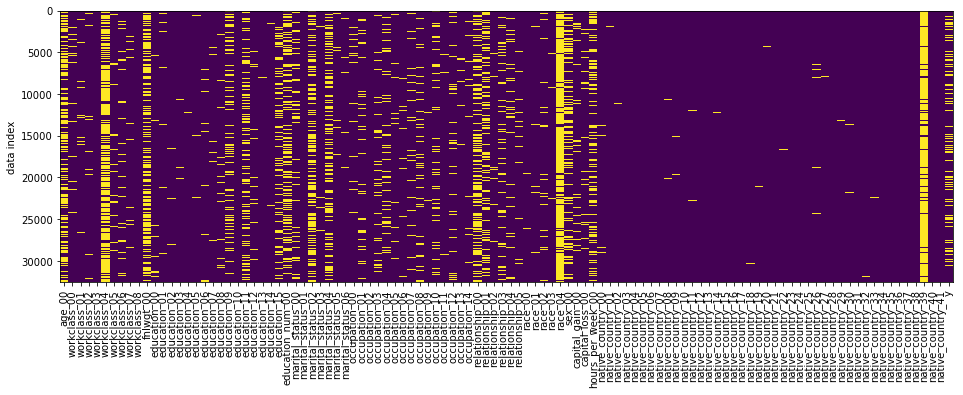

In [3]:
print('')
print('X.shape', '\t', X.shape)
print('Y.shape', '\t', Y.shape)
print()
print('mean(Y)', np.mean(Y))

figure = lambda : plt.figure(figsize=(16,5))
figure()
plt.imshow(np.hstack((X,Y)))
plt.axis('auto')
plt.ylabel('data index');
plt.gca().set_xticks(list(range(X.shape[1]+1)))
plt.gca().set_xticklabels(binary_feature_names+['y'], rotation='vertical')

ntrain = 1200
ishuffle = np.arange(X.shape[0])
np.random.seed(0)
np.random.shuffle(ishuffle)
itrain = ishuffle[slice(0,ntrain)]
itest = ishuffle[slice(ntrain,None)]
X_train, Y_train = X[itrain,:], Y[itrain,:]
X_test, Y_test = X[itest,:], Y[itest,:]

## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.

### <span style="color:blue">Answer</span>
#### Q1 i.i.d assumption

> i.i.d means independent and identically distributed, it states that random variable has the same probability distribution as the others and all are mutually independent and Identically distributed.

> In naive bayes classifier, i.i.d assumption allow us to reduce the total number of paramaters in likelyhood calculation, because we can simply take the product of all independent and identically distributed

$$\rho = \{\rho_{j,k}\}$$

$$p(D|\rho,\mu)=p((x_1,y_1),\dots,p(x_i,y_i)|\rho,\mu)=\prod^{n}\limits_{i=1}p((x_i,y_i)|\rho,\mu) \tag{i.i.d}$$

##### Q2 Maximum Likelyhood Estimate

$$L(\mathcal{D}|\rho,\mu)=\prod^{n}\limits_{i=1}p(x_i,y_i)=\prod^{n}\limits_{i=1}p(x_i|y_i)p(y_i)\tag{i.i.d}
$$
> $N_{jk}$ is the count of $x_j=1$ given $y=k$  $\qquad N_k$ is the total count of $y=k$

$$L(\mathcal{D}|\rho,\mu)=\prod^{d}\limits_{j}\prod^{K}\limits_{k=0}p(x_j=1|y=k)^{N_{j,k}}p(x_j=0|y=k)^{N_k-N_{j,k}}\cdot p(y_i=0)^{N_{k=1}}p(y_i=1)^{n-N_{k=1}}$$

> We have $p(x_j=1|y=k)=\rho_{j,k}$ and $p(x_j=0|y=k)=1-\rho_{j,k}$

$$\hat{\rho_{j,k}},\hat{\mu}=\argmax\limits_{\rho_{j,k}\mu}logL(\mathcal{D}|\rho,\mu)=\sum^d\limits_{j=1}\sum^K\limits_{k=0}N_{j,k}log\rho_{j,k}-(N_k-N_{j,k})log(1-\rho_{j,k})+[(n-N_{k=1})log(1-\mu)+N_{k=1}log\mu] $$

$$\frac{\partial}{\mu}logL(\rho,\mu)=\frac{n-N_{k=1}}{1-\mu}-\frac{N_k}{\mu}=0$$

$$\hat{\mu}=\frac{N_{k=1}}{n}=\frac{1}{n}\sum^n_{i=1}y_i$$

$$\frac{\partial}{\rho_{j,k}}logL(\rho,\mu)=\sum^d\limits_{j=1}\sum^K\limits_{k=0}[\frac{N_{j,k}}{\rho_j,k}-\frac{N_k-N_{j,k}}{1-\rho_{j,k}}]=0$$

$$\hat{\rho_{j,k}}=\frac{N_{j,k}}{N_k} $$

**NOTE** *$N_{jk}$ is the count of $x_j=1$ given $y=k$  $\qquad N_k$ is the total count of $y=k$*

#### Q3 implement training function

In [4]:
def MLE_train(X_train,Y_train):
    #count Njk,Nk
    true_rows=X_train[np.where(Y_train==1)[0]]
    false_rows=(X_train[np.where(Y_train==0)[0]]==True)
    rho_true=np.sum(true_rows,0)/np.sum(Y_train)
    rho_false=np.sum(false_rows,0)/(Y_train.shape[0]-np.sum(Y_train))
    rho = np.stack((rho_true,rho_false))
    mu =np.sum(Y_train)/Y_train.shape[0]
    return rho,mu

#### Q4 Plot the  figure

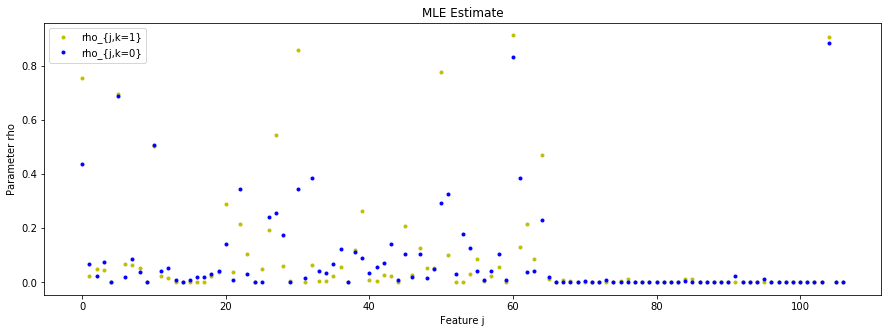

In [5]:
#Train paramater using mle
rho_mle,mu_mle=MLE_train(X_train,Y_train)
fig = plt.figure(figsize=(15,5))

plt.plot(range(X_train.shape[1]),rho_mle[0],'y.',label='rho_{j,k=1}')
plt.plot(range(X_train.shape[1]),rho_mle[1],'b.',label='rho_{j,k=0}')
plt.legend()
plt.xlabel('Feature j')
plt.ylabel('Parameter rho')
plt.title('MLE Estimate')
plt.show()

#### Q5 Print the number of $\rho_{j,k}$ which are zero

In [6]:
#Plot the number of rho_{j,k}=0
rho_k1=np.where(rho_mle[0,:]==0)[0].shape[0]
rho_k0=np.where(rho_mle[1,:]==0)[0].shape[0]
print('Number of rho_j,k=1 is:',rho_k1)
print('Number of rho_j,k=0 is:',rho_k0)
print('Total number of rho_j,k=0 is:',rho_k1+rho_k0)

Number of rho_j,k=1 is: 36
Number of rho_j,k=0 is: 15
Total number of rho_j,k=0 is: 51


#### Q6 Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.
If one of $\rho_{j,k}$ is zero, the product will be zero, so the probability of likelyhood will turn to zero. The 0 probility also means this feature is impossible to have change, in other word, it useless. 

## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution. 
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

### <span style="color:blue">Answer</span>
#### Q1 Derive the maximum a posteriori

   $$p(\rho_{j,k},\mu|\mathcal{D})=\frac{p(\mathcal{D}|\rho_{j,k},\mu)p(\rho_{j,k},\mu)}{p(\mathcal{D})}\tag{Bayes theorem}$$ 
   
  > Dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ Posterior:
  
  $$p(\rho_{j,k},\mu|\mathcal{D})\propto p(\mathcal{D}|\rho_{j,k},\mu)p(\rho_{j,k},\mu)$$
   
  > Because $p(\rho_{j,k})$ and uniform prior $p(\mu)=1$ are independent, the joint distribution $p(\rho_{j,k},\mu)= p(\rho_{j,k})p(\mu)=p(\rho_{j,k})$
  
  $$\hat{\rho_{j,k}},\hat{\mu}=\argmax_{\rho_{j,k},\mu}p(\mathcal{D}|\rho_{j,k},\mu)p(\rho_{j,k})p(\mu)$$
  
  > $N_{jk}$ means the count of $x_j=1$ given $y=k$  $\qquad N_k$ means the total count of $y=k$
  
  $$\hat{\rho_{j,k}},\hat{\mu}=\argmax\limits_{\rho_{j,k},\mu}log p(\mathcal{D}|\rho_{j,k},\mu)p(\rho_{j,k},\mu)=$$

  $$\argmax_{\rho_{j,k},\mu}\sum^d\limits_{j=1}\sum^K\limits_{k=0}N_{j,k}log\rho_{j,k}-(N_k-N_{j,k})log(1-\rho_{j,k})+(\beta-1)log\rho_{j,k}+(\beta-1)log(1-\rho_{j,k})-Z(\beta)+[(n-N_{k=1})log(1-\mu)+N_{k=1}log\mu]$$
  
  $$\frac{\partial}{\rho_{j,k}}logL(\rho,\mu)=\sum^d\limits_{j=1}\sum^K\limits_{k=0}[\frac{N_{j,k}+\beta-1}{\rho_{j,k}}-\frac{N_k-N_{j,k}+\beta-1}{1-\rho_{j,k}}]=0$$
  
  $$\hat{\rho_{j,k}}=\frac{N_{j,k}+\beta-1}{N_k+2(\beta-1)}$$
  
  $$\frac{\partial}{\mu}logL(\rho,\mu)=\frac{n-N_{k=1}}{1-\mu}-\frac{N_k}{\mu}=0$$
  
  $$\hat{\mu}=\frac{N_{k=1}}{n}=\frac{1}{n}\sum^n_{i=1}y_i$$

#### Q2  Implement a function which computes these maximum a posteriori parameters

In [7]:
def MAP_train(X_train,Y_train,beta):
    true_rows=X_train[np.where(Y_train==1)[0]]
    false_rows=(X_train[np.where(Y_train==0)[0]]==True)
    #rho_true is rho for p(x_j=1|y)=1 
    rho_true=(np.sum(true_rows,0)+beta-1)/(np.sum(Y_train)+2*(beta-1))
    #rho_false is rho for p(x_j=1|y)=1 
    rho_false=(np.sum(false_rows,0)+beta-1)/((Y_train.shape[0]-sum(Y_train))+2*beta-1)
    rho = np.stack((rho_true,rho_false))
    mu =np.sum(Y_train)/Y_train.shape[0]
    return rho,mu

#### Q3 Verify with ```assert np.allclose()``` that the m.a.p. 

In [8]:
beta=1
rho_map,mu_map=MAP_train(X_train,Y_train,beta)
#beta=1 means no prior so MAP is as same as MLE
assert np.allclose(rho_mle[0],rho_map[0], rtol=1e-5, atol=0)

#### Q4 Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$.

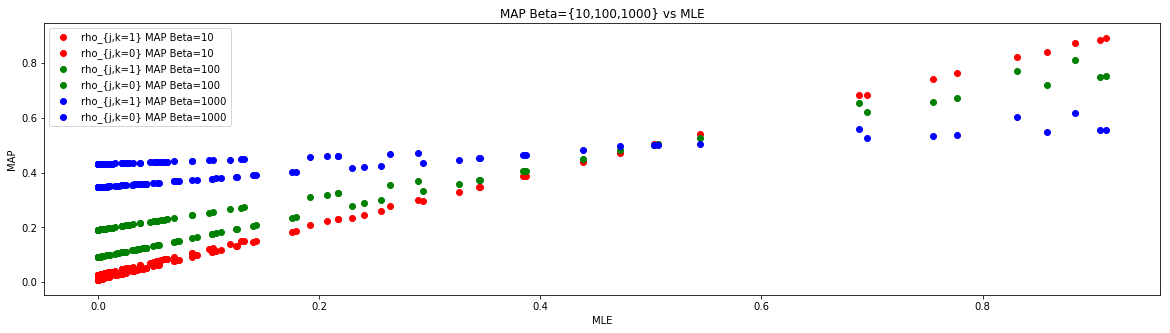

In [9]:
beta_value={'Beta=10':10,'Beta=100':100,'Beta=1000':1000}
fig=plt.figure(figsize=(20,5))

#Compute and plot MAP for beta=10
rho_map_beta10,mu_map_beta10=MAP_train(X_train,Y_train,beta_value['Beta=10'])
plt.scatter(rho_mle[0],rho_map_beta10[0],c='r',label='rho_{j,k=1} MAP Beta=10')
plt.scatter(rho_mle[1],rho_map_beta10[1],c='r',label='rho_{j,k=0} MAP Beta=10')

#Compute and plot MAP for beta=100
rho_map_beta100,mu_map_beta100=MAP_train(X_train,Y_train,beta_value['Beta=100'])
plt.scatter(rho_mle[0],rho_map_beta100[0],c='g',label='rho_{j,k=1} MAP Beta=100')
plt.scatter(rho_mle[1],rho_map_beta100[1],c='g',label='rho_{j,k=0} MAP Beta=100')

#Compute and plot MAP for beta=1000
rho_map_beta1000,mu_map_beta1000=MAP_train(X_train,Y_train,beta_value['Beta=1000'])

plt.scatter(rho_mle[0],rho_map_beta1000[0],c='b',label='rho_{j,k=1} MAP Beta=1000')
plt.scatter(rho_mle[1],rho_map_beta1000[1],c='b',label='rho_{j,k=0} MAP Beta=1000')
plt.legend()
plt.xlabel('MLE')
plt.ylabel('MAP')
plt.title('MAP Beta={10,100,1000} vs MLE')

#### Q5 Give one example of the role of $\beta$ as evidenced by the plot.

> if we look at red color, we can see the result of MAP with little $\beta(\beta=10)$ only have a slight difference to the result of MLE. By contrast, a big $\beta(\beta=1000)$ which is blue color shows it's dramatically different between MAP and MLE. Because big $\beta$ of prior means we have enough confidence believe $\rho_{j,k}$ close to $\frac{1}{2}$ and the prior dominate the result of parameter estimation.

## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

### <span style="color:blue">Answer</span>


#### Q1 
$p(y=1|\mathbf{x})=\frac{p(\mathbf{x}|y=1)p(y=1)}{p(\mathbf{x}|y=1)p(y=1)+p(\mathbf{x}|y=0)p(y=0)}=\frac{\prod^n\limits_{j=1}\rho_{j,k=1}^{x_j}(1-\rho_{j,k=1})^{1-x_j}\mu}{\prod^n\limits_{j=1}\rho_{j,k=1}^{x_j}(1-\rho_{j,k=1})^{1-x_j}\mu+\prod^n\limits_{j=1}\rho_{j,k=0}^{x_j}(1-\rho_{j,k=0})^{1-x_j}\mu}=\frac{A}{A+B} \tag{Bayes Rule and i.i.d}$
$$\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)=log(\frac{A}{A+B})=logA-log(A+B)$$

$$logA=\sum^n\limits_{j=1}x_jlog\rho_{j,k=1}+\sum^n\limits_{j=1}(1-x_j)log(1-\rho_{j,k=1})+log\mu$$
$$logB=\sum^n\limits_{j=1}x_jlog\rho_{j,k=0}+\sum^n\limits_{j=1}(1-x_j)log(1-\rho_{j,k=0})+log\mu$$


In [10]:
def P_y_equal_1_X(X_test,rho,mu):
    #calculate part of logA,logB
    logRho_P_jk1=np.matrix(np.log(rho[0])).T
    logRho_N_jk1=np.matrix(np.log(1-rho[0])).T
    logRho_P_jk0=np.matrix(np.log(rho[1])).T
    logRho_N_jk0=np.matrix(np.log(1-rho[1])).T
    #substitution
    logA=X_test@logRho_P_jk1+(1-X_test)@logRho_N_jk1+np.log(mu)
    logB=X_test@logRho_P_jk0+(1-X_test)@logRho_N_jk0+np.log(1-mu)
    result = logA-np.logaddexp(logA,logB)
    return result

#### Q2 Call the above funcion on X_test using m.a.p. parameters computed with  β=2

In [11]:
rho_map_beta2,mu_map_beta2=MAP_train(X_train,Y_train,beta=2)
result=P_y_equal_1_X(X_test,rho_map_beta2,mu_map_beta2)

#### Q3 Plot a histogram of the probabilities

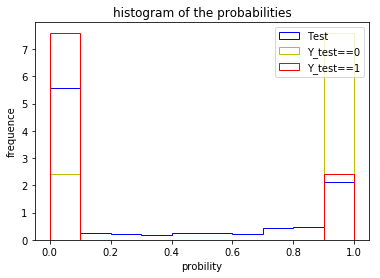

In [12]:
yTest0=(Y_test==0)
yTest1=(Y_test==1)
plt.hist (np.exp(result),color='b',normed=True,histtype='step',label='Test')#,range(X_test.shape[0]),result)
plt.hist (yTest0,color='y',normed=True,histtype='step',label='Y_test==0')
plt.hist (yTest1,color='r',normed=True,histtype='step',label='Y_test==1')
plt.title('histogram of the probabilities')
plt.xlabel('probility')
plt.ylabel('frequence')
plt.legend()

## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.

In [13]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

### <span style="color:blue">Answer</span>

#### Q1 Write a function evaluate

In [14]:
def evaluate(X,Y,rho,mu):
    #Calculate the probility of p(y=1|x)
    logp=P_y_equal_1_X(X,rho,mu)
    p =np.exp(logp)
    logp_true = Y*np.array(1+np.exp(-p))+(1-Y)*np.array(1+np.exp(p))

    #Get mean
    mean_logp_true=np.mean(logp_true)
    num_data=Y.shape[0]
    #Compute the accuracy rate(percent)
    percent_correct=(np.sum(((np.exp(logp)>0.5)==Y)))/num_data*100
    return {'mean_logp_true':mean_logp_true,'percent_correct':percent_correct}

#### Q2 Write a function cross_validate(beta, nfolds, X, Y)

In [15]:
def cross_validate(beta, nfolds, X, Y):
    mean_logp_true=0
    percent_correct=0
    #if it can not divide nfolds, throw some data
    data_length=X_test.shape[0]- (X_test.shape[0] % nfolds)
    cross_Xdata=xval_inds(data_length, nfolds)
    cross_Ydata=xval_inds(data_length, nfolds)
    #for each dataset i.e. ((data_Xtrain,data_Ytrain),(data_Xtest,data_Ytest))
    for data_Xset,data_Yset in zip(cross_Xdata,cross_Ydata):
        data_Xtrain=X[data_Xset[0]]
        data_Xtest=X[data_Xset[1]]
        data_Ytrain=Y[data_Yset[0]]
        data_Ytest=Y[data_Yset[1]]
        #Train by train set
        rho_map,mu_map=MAP_train(data_Xtrain,data_Ytrain,beta)
        #Evaluate acurracy by test set
        result=evaluate(data_Xtest,data_Ytest,rho_map,mu_map)
        mean_logp_true += result['mean_logp_true']
        percent_correct += result['percent_correct']
    return {'mean_logp_true':mean_logp_true/nfolds,'percent_correct':percent_correct/nfolds}

#### Q3 Plot cross_valid 
**NOTE** * it takes a little bit time depend on how many folds you set*

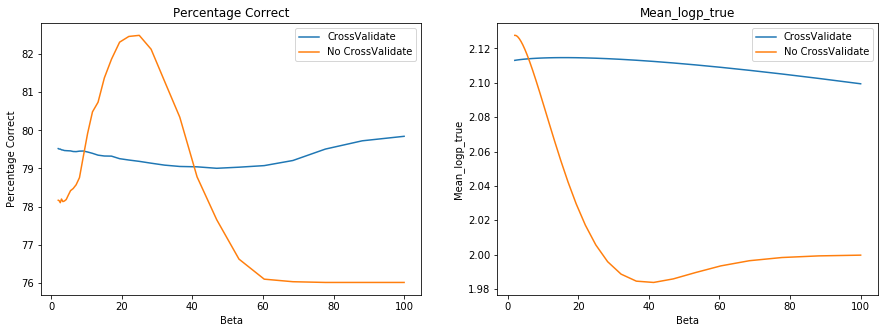

In [16]:
#plotlist, turn result dict to list
cross_correct=[]
cross_meanlogp_true=[]
no_cross_correct=[]
no_cross_meanlogp_true=[]

#for each beta in logspace 
for beta in np.logspace(np.log10(2),2,32):
    #cross valid result add to plotlist
    cross_result=cross_validate(beta, 10, X_test, Y_test)
    cross_correct.append(cross_result['percent_correct'])
    cross_meanlogp_true.append(cross_result['mean_logp_true'])
    
    #Train & Test without cross valid directly
    rho,mu=MAP_train(X_train,Y_train,beta)
    no_cross_result=evaluate(X_test,Y_test,rho,mu)
    no_cross_correct.append(no_cross_result['percent_correct'])
    no_cross_meanlogp_true.append(no_cross_result['mean_logp_true'])
    

fig=plt.figure(figsize=(15,5))
sub_1=fig.add_subplot(121)
#plo
sub_1.plot(np.logspace(np.log10(2),2,32),cross_correct,label='CrossValidate')
sub_1.plot(np.logspace(np.log10(2),2,32),no_cross_correct,label='No CrossValidate')
#set axis 
#sub_1.set_ylim([0,100])
sub_1.set_title('Percentage Correct')
sub_1.set_ylabel('Percentage Correct')
sub_1.set_xlabel('Beta')
sub_1.legend()
sub_2=fig.add_subplot(122)
#plot curve
sub_2.plot(np.logspace(np.log10(2),2,32),cross_meanlogp_true,label='CrossValidate')
sub_2.plot(np.logspace(np.log10(2),2,32),no_cross_meanlogp_true,label='No CrossValidate')
sub_2.set_title('Mean_logp_true')
sub_2.set_ylabel('Mean_logp_true')
sub_2.set_xlabel('Beta')
sub_2.legend()


## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?

### <span style="color:blue">Answer</span>

1. The transfomation of continous variables loss a lot of information, we only care about whether it greater or smaller than mean but we ignore the variance of distribution. Secondly, the feature on nation are seperated into 41 booleans, but most of them locate in one country, which greatly increase the dimension.
2. As for the model, if we look at the data distribution, the feature from native_country_1 to native_country_41 most distribute in native_country_39. Maybe we can change this nation feature to whether belong to native_country_39 or not. It could greatly reduce the feature dimension.
3. 

> $p(a,b,c)$ has $7$ paramater ($2^n-1 = 2^3-1 =7$)

> $p(a|c)$ has $2$ paramater 
  
> $p(b|c)$ has $2 $ paramater
  
> $p(c)$ has $1 $ paramater
  
> $p(a|c)p(b|c)p(c)$ has $5$ paramater

## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer</span>



$$w=\sum^N\limits_{n=1}a_n\phi(x_n)+w_{\perp}$$

> we assume 

$$w^\top_\perp \cdot \sum^N\limits_{n=1}a_n\phi(x_n)=\sum^N\limits_{n=1}a_nw^\top_\perp\phi(x_n)=0$$

> rewrite 

$$\quad\quad w_0 = \sum^N\limits_{n=1}a_n\phi(x_n)$$

> now we have

$$w=w_0+w_\perp$$

$$w^\top_{\perp}w_0=0$$

$$J(\mathbf{w}) = f((w_0+w_\perp)^\top \phi(\mathbf{x}_1), \ldots, (w_0+w_\perp)^\top \phi(\mathbf{x}_N)) + g((w_0+w_\perp)^\top(w_0+w_\perp)) \tag{Substitution}$$

$$J(\mathbf{w}) = f((w_0+w_\perp)^\top \phi(\mathbf{x}_1), \ldots, (w_0+w_\perp)^\top \phi(\mathbf{x}_N)) + g(w_0^\top w_0+w_0^\top w_\perp+w_\perp^\top w_0+w_\perp^\top w_\perp) $$

> since 
    
$$w^\top_{\perp}w_0=0 \qquad\qquad w_0^\top w_\perp=0$$

$$J(\mathbf{w}) = f(w_0^\top \phi(\mathbf{x}_1), \ldots, w_0^\top \phi(\mathbf{x}_N)) + g(w_0^\top w_0+w_\perp^\top  w_\perp) $$

$$w = {argmin}_w J(w)=min f(\cdot)+min g(\cdot)$$

> $g(\cdot)$ is a monotonically increasing function 

$$ \qquad w_0^\top w_0 \geq 0 \qquad and \qquad  w_\perp^\top  w_\perp \geq 0$$

> when $w_\perp^\top  w_\perp =0 \qquad\qquad\qquad g(w_0^\top w_0+w_\perp^\top  w_\perp)$ have minimise value  

$$ w_\perp = 0$$

> So
  
$$w = \sum^N\limits_{n=1}a_n\phi(x_n)+0$$
  

## (2 points) Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} = 
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$, 
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the 
data $ X_4 $ have been observed and 
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.

### <span style="color:blue">Answer</span>
#### Q1
 $$\theta_{ML}= \argmax_{\theta}p(X_4|\theta)=\argmax_{\theta}p(x_1,x_2,x_3,x_4|\theta)=argmax_{\theta}\prod^{4}\limits_{n=1}p(x_n|\theta) \tag{i.i.d}$$
$$
p(X_4|\theta) = 
\begin{cases}
 \frac{1}{\theta^4} & 0 \leq x_n \leq \theta & and &x_n \in X_4\\
 0        & \textrm{otherwise} \\
\end{cases}
$$

> if we want to maximum the likelyhood, $\theta$ should be choosed minimum, but $\theta$ should also satisfy another limit condition $0\leq x_n \leq \theta$,which means $\theta$ should at least equal or greater than 9

$$\theta_{ML}=max\{X_4\}=9$$

#### Q2 

$$p(\theta|X_4) = \frac{p(X_4|\theta)p(\theta)}{p(X_4)} \tag{Bayes Theorem}$$

$$p(\theta|X_4) = \frac{p(X_4|\theta)p(\theta)}{\int_0^{+\infty}p(X_4|\theta)p(\theta)d\theta} \tag{Sum Rule}$$

$$p(\theta|X_4) = \frac{p(X_4|\theta)\cdot p(\theta)}{\int_0^{+\infty}p(X_4|\theta)p(\theta)d\theta}$$



> $\int_0^{9}p(X_4|\theta)p(\theta)d\theta=0\qquad $ because $x_4=9$ so $\theta\geq x_4$ $p(\theta)=0$

> $\int_{10}^{+\infty}p(X_4|\theta)p(\theta)d\theta=0\qquad$ because $p(\theta)=\DUniform{x}{0}{10}$

$$p(\theta|X_4) = \frac{p(X_4|\theta)\cdot p(\theta)}{\int_9^{10}p(X_4|\theta)p(\theta)d\theta}$$

> We have known the prior $p(\theta)=\DUniform{x}{0}{10}$, Meanwhile $p(\theta)\neq0$

$$p(\theta)=0.1$$

$$p(\theta|X_4) = \frac{\frac{1}{\theta^4}\cdot 0.1}{\int_9^{10}\frac{1}{\theta^4}\cdot 0.1d\theta}$$

$$p(\theta|X_4) = \frac{\frac{1}{\theta^4}}{-\frac{1}{3\theta^3}\bigg|^{10}_{9}}$$

$$p(\theta|X_4) = \frac{8070.1107}{\theta^4}$$

$$
p(\theta|X_4) = 
\begin{cases}
 \frac{8070.1107}{\theta^4} & 0 \leq x_n \leq \theta & and &x_n \in X_4\\
 0        & \textrm{otherwise} \\
\end{cases}
$$

#### Q3 the maximum a posteriori estimate of  θ

$$p(\theta|X_4) \propto \frac{p(X_4|\theta)p(\theta)}{p(X_4)}$$

$$\theta_{MAP} = \argmax_{\theta} p(X_4|\theta)p(\theta) \tag{Bayes Rule}$$

$$\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)\cdot 0.1$$

> we want to maximum the MAP, $\theta$ should be choosed minimum, but $\theta$ should also satisfy another limit condition $0\leq x \leq \theta$,which means $\theta$ should at least greater than 9

$$\theta_{MAP} = max\{X_n\}=9$$

#### Q4 

> $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ The result should be the same because all observation are independent and identically follow the same distribution.

$$\theta_{ML} = 9$$

$$\theta_{MAP} = 9$$

$$
M.A.P=p(\theta|X_4) = 
\begin{cases}
 \frac{8070.1107}{\theta^4} & 0 \leq x_n \leq \theta & and &x_n \in X_4\\
 0        & \textrm{otherwise} \\
\end{cases}
$$

## (2 points) Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation 
$$
  \int_0^{\infty} f(z) \mathrm{d}z 
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z 
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a 
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?

# <span style="color:blue">Answer</span>
#### Q1 Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

>take the 1st order deravetive of $f(z)$ equal to zero
   
$$\frac{df(z)}{dz} = kz^{k-1}e^{-z^2/2}-z^{k+1}e^{-z^2/2}=0$$

$$z_0=\sqrt{k}\qquad z_1=-\sqrt{k}$$

> Since $z \in [0, \infty)$ we only keep the extreme point $z_0$

$$z=\sqrt{k}$$

> for any $z \in [0, \sqrt{k})$ 
        
$$f(z)>0 \qquad z \in [0, \sqrt{k})$$

> for any $z \in (\sqrt{k}, \infty)$ 

$$f(z)<0 \qquad z \in (\sqrt{k}, \infty)$$

> So f(x) it's have only one maximum value

#### Q2 Using Laplace approximation find $\mu$ and $\sigma$ of gaussian

$$
  F(z)=\int_0^{\infty} f(z) \mathrm{d}z 
$$

> We know, we can use Taylor Series as an expansion of a function into an infinite sum of terms, but we only keep until second order. Meanwhile the center is $z_0$ which is also the $\mu$ of gaussian  

$$lnf(z) \approx lnf(z_0)- \frac{C}{2}(z-z_0)^2 \qquad  and \qquad C=-\frac{\partial^2}{\partial z^2}lnf(z)\bigg|_{z=z_0} $$

> Take exponenent in both side we get unnormalised gaussian distribution 

$$f(z)=exp(lnf(z))\approx f(z_0)exp\{-\frac{C}{2}(z-z_0)^2\}$$

> Normalised Gaussian Distribution:

$$f(z)\approx \sqrt{\frac{C}{2\pi}}exp\{-\frac{C}{2}(z-z_0)^2\}$$

> so the $\mu$ and $\sigma$ of guassian distribution

$$\mu = z_0=\sqrt{k}\qquad \qquad \sigma^2=\frac{1}{C}$$

#### Q3 use python to find normalisation of f(z)

In [17]:
def compute_normalisation(k):
    a=0
    integral_area=0
    for i in range(100):
        a+=0.1
        fz=a**k*(np.e**(-(a**2)/2))
        integral_area+=0.1*fz
    return integral_area

In [18]:
print('Normalisation with 0.5 is: {0:.5f}'.format(compute_normalisation(0.5)))
print('Normalisation with 3 is: {0:.5f}'.format(compute_normalisation(3)))
print('Normalisation with 5 is: {0:.5f}'.format(compute_normalisation(5)))

Normalisation with 0.5 is: 1.02387
Normalisation with 3 is: 2.00000
Normalisation with 5 is: 8.00000


In [19]:
'''
Use sympy to calculate symbol formular
This could greatly improve our efficiency
'''
from sympy import *
def plt_approximate(k_val):
    z=np.arange(0,10,0.1)
    #plot original distribution 
    fz=z**k_val*(np.e**(-(z**2)/2))
    normalised_fz=fz/compute_normalisation(k_val)
    plt.plot(z,normalised_fz,label='f(z) k='+str(k_val))
    
    '''
    Compute the Gaussian distribution
    '''
    #initial set z,z0,k as a symbol
    z,z0,k=symbols('z z0 k')
    fz=z**k*E**(-(z**2)/2)
    
    #compute 1st order of lnf(z)
    dfz=diff(log(fz),z)
    #compute 2nd order derivative of lnf(z)
    ddfz=diff(dfz,z)
    #C=-ddfz
    C=-ddfz
    #z0=z0
    z0=sqrt(k)
    #substitude z0 into C
    C=C.subs(z,z0)

    norm_gaussain=sqrt(C/(2*pi))*exp(-C/2*(z-z0)**2)

    zi=np.arange(0,10,0.1)
    
    gaussainlist=[]
    for i in zi:
        #substitution
        norm_gaussain=norm_gaussain.subs(k,k_val)
        gaussainlist.append(norm_gaussain.subs(z,i))
    plt.plot(zi,gaussainlist,label='Gaussian k='+str(k_val))
    plt.legend()

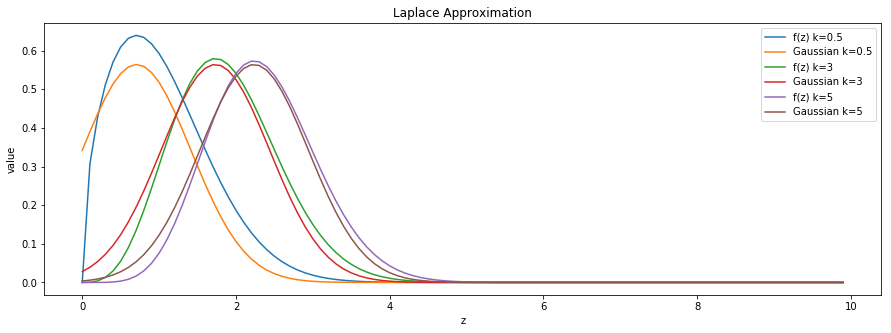

In [20]:
#plot this three figure with different k
fig=plt.figure(figsize=(15,5))
plt_approximate(0.5)
plt_approximate(3)
plt_approximate(5)
plt.xlabel('z')
plt.ylabel('value')
plt.title('Laplace Approximation')
plt.show()

#### Q5 Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $

> Most area distributes in the center ($z=\sqrt{k}$), Specifically, $95\%$ of integral area located in $\pm2\sigma$, if $2\sigma <10$ we can work out that the integral area is close to zero after a>10, so it doesn't have influence on the integral result.